In [2]:
'''
Copyright (c) <2014>, <Tom Augspurger>
All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are 
permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS 
"AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, 
BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND 
FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL 
THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, 
INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, 
BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; 
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER 
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, 
STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) 
ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
'''
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Classify new features:

- child : age < 16
- woman_or_child

In [6]:
#print dict(male="man",female="women")#["male"]
help(pd.factorize)


Help on function factorize in module pandas.core.algorithms:

factorize(values, sort=False, order=None, na_sentinel=-1, size_hint=None)
    Encode input values as an enumerated type or categorical variable
    
    Parameters
    ----------
    values : ndarray (1-d)
        Sequence
    sort : boolean, default False
        Sort by values
    order : deprecated
    na_sentinel : int, default -1
        Value to mark "not found"
    size_hint : hint to the hashtable sizer
    
    Returns
    -------
    labels : the indexer to the original array
    uniques : ndarray (1-d) or Index
        the unique values. Index is returned when passed values is Index or Series
    
    note: an array of Periods will ignore sort as it returns an always sorted PeriodIndex



In [3]:
df = pd.read_csv('data/train.csv', index_col=0)
def preprocess(df):
    df.columns = df.columns.map(lambda x: x.lower())

    def woman_child_or_man(passenger):
        age, sex = passenger
        if age < 16:
            return "child"
        else:
            return dict(male="man", female="woman")[sex]

    df['who'] = df[['age', 'sex']].apply(woman_child_or_man, axis=1)
    df["alone"] = ~(df.parch + df.sibsp).astype(bool)
    df["class"] = df.pclass.map({1: "First", 2: "Second", 3: "Third"})
    df["deck"] = df.cabin.str[0].map(lambda s: np.nan if s == "T" else s)

    df['sex_f'] = df.sex.map({'male': 0, 'female': 1})
    df = df.rename(columns={'pclass': 'class_f'})
    embarked_values, embarked_labels = pd.factorize(df.embarked)
    df['embarked_f'] = embarked_values
    df['embarked_f'] = df.embarked_f.replace({-1: np.nan})
    
    return df

df = preprocess(df)

Bit of visualization before diving in (for a better version see http://nbviewer.ipython.org/gist/mwaskom/8224591)

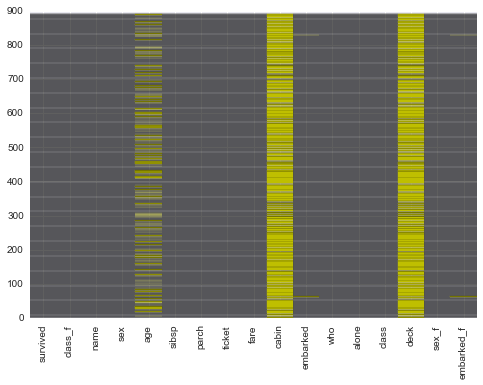

In [3]:
from missmap import missmap
missmap(df)

Demographics on Passengers

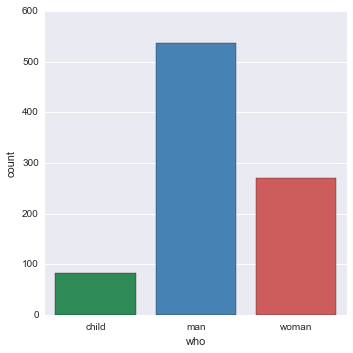

In [4]:
pal = dict(man="#4682B4", woman="#CD5C5C", child="#2E8B57", male="#6495ED", female="#F08080",
           First="#33CC99", Second="#006699", Third="#E3CEF6")

sns.factorplot("who", data=df, palette=pal)

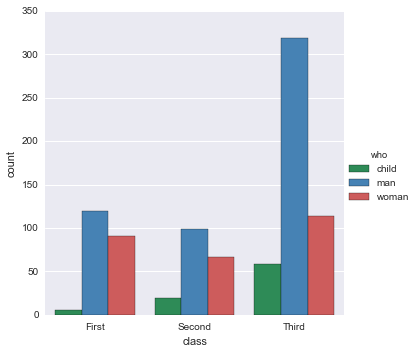

In [5]:
sns.factorplot("class", data=df, hue="who", palette=pal)

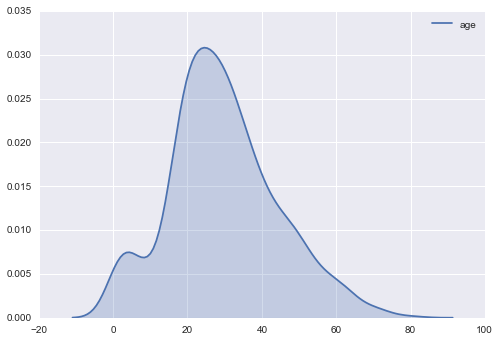

In [6]:
ax = sns.kdeplot(df.age, shade=True)
# ax.set_xlim(0, 80)  # matplotlib doesn't redraw

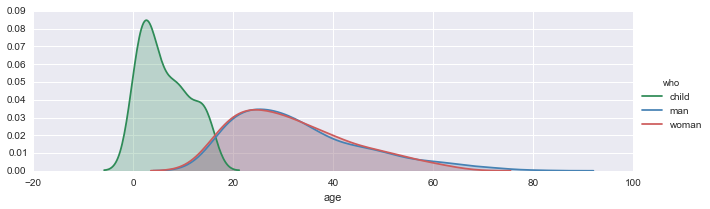

In [7]:
g = sns.FacetGrid(df, hue="who", aspect=3, palette=pal)
g.map(sns.kdeplot, "age", shade=True)

In [8]:
# who's age is missing
df['bad_age'] = pd.isnull(df.age)
df.groupby(['sex', 'class'])['bad_age'].agg('sum') 

sex     class 
female  First      9
        Second     2
        Third     42
male    First     21
        Second     9
        Third     94
Name: bad_age, dtype: float64

In [9]:
# relative
df['bad_age'] = pd.isnull(df.age)
df.groupby(['sex', 'class'])['bad_age'].agg('mean')

sex     class 
female  First     0.095745
        Second    0.026316
        Third     0.291667
male    First     0.172131
        Second    0.083333
        Third     0.270893
Name: bad_age, dtype: float64

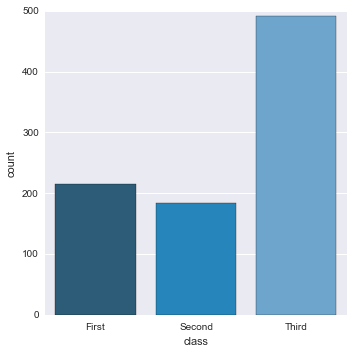

In [10]:
sns.factorplot("class", data=df, palette="PuBu_d")

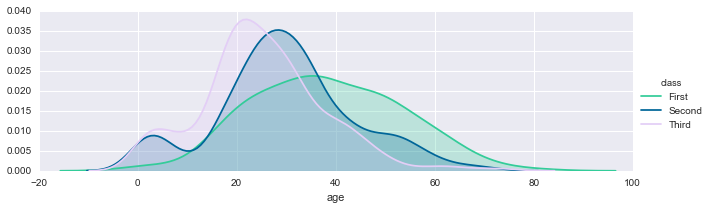

In [11]:
g = sns.FacetGrid(df, hue="class", aspect=3, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
#g.set(xlim=(0, 80))

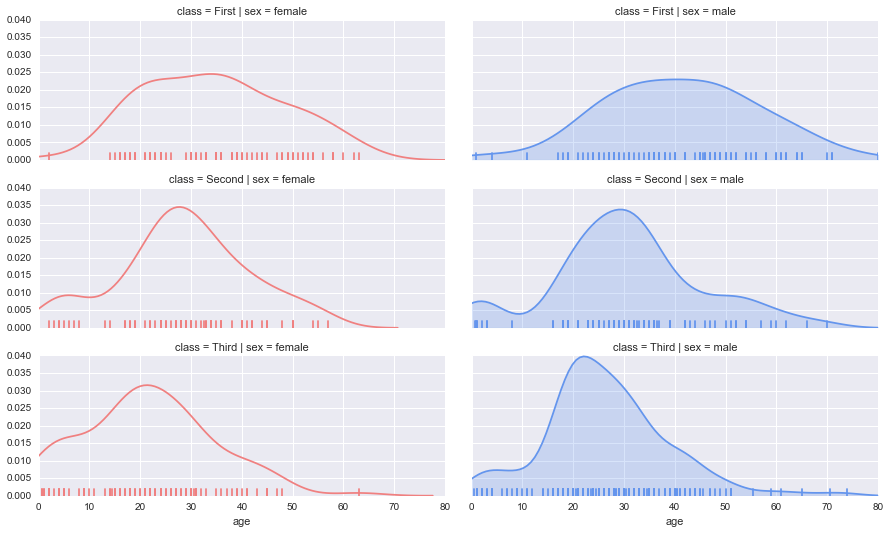

In [12]:
fg = sns.FacetGrid(df, col="sex", row="class", hue="sex", size=2.5, aspect=2.5, palette=pal)
fg.map(sns.kdeplot, "age", shade=True)
fg.map(sns.rugplot, "age")
sns.despine(left=True)
fg.set(xlim=(0, 80));


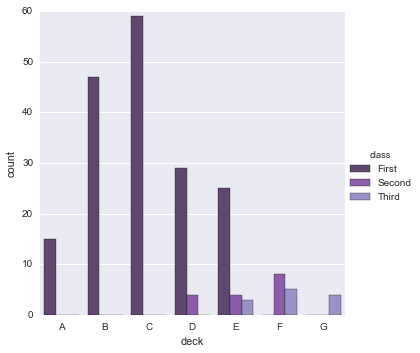

In [13]:
sns.factorplot("deck", hue="class", data=df, palette="BuPu_d"); 

## Who Survived?

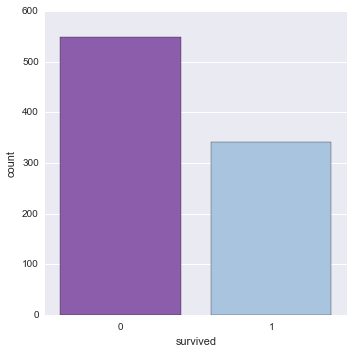

In [14]:
sns.factorplot("survived", data=df, palette="BuPu_r")

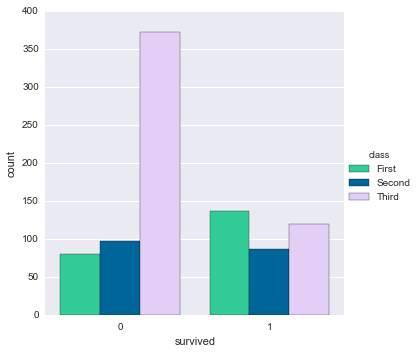

In [15]:
sns.factorplot("survived", data=df, hue="class", palette=pal)

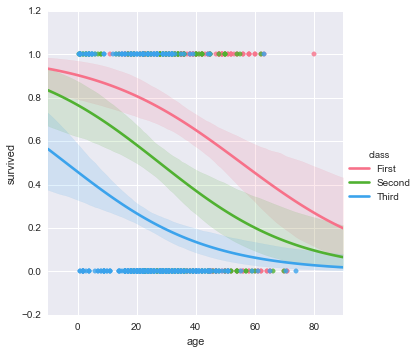

In [16]:
sns.lmplot("age", "survived", df, hue="class", logistic=True)

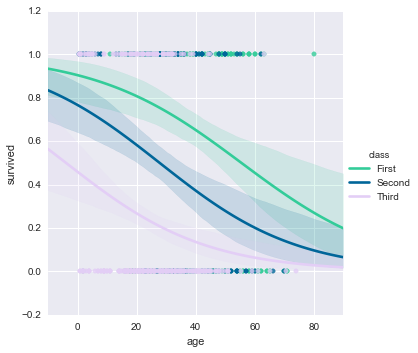

In [17]:
sns.lmplot("age", "survived", df, hue="class", palette=pal, logistic=True)

# Modelling

In [18]:
feature_labels = ['class_f', 'sex_f', 'age', 'sibsp', 'parch', 'fare', 'alone',
                  'sex_f', 'embarked_f']
idx = df[feature_labels].dropna().index
X = df.loc[idx, feature_labels].values
y = df.survived.loc[idx]

In [19]:
test = pd.read_csv('test.csv')
test = preprocess(test)

yhats = {}  # for later

In [20]:
pd.isnull(test).any()

passengerid    False
class_f        False
name           False
sex            False
age             True
sibsp          False
parch          False
ticket         False
fare            True
cabin           True
embarked       False
who            False
alone          False
class          False
deck            True
sex_f          False
embarked_f     False
dtype: bool

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation as cv
from sklearn.grid_search import GridSearchCV

### Naive

In [22]:
clf = LogisticRegression()
clf.fit(X, y)
yhats['yhat_logistic_0'] = clf.predict(test[feature_labels].values)
print("Training Score: ", clf.score(X, y))

Training Score:  0.800561797753


## $\ell_1$ Penalty

In [23]:
clf = LogisticRegression(penalty="l1")
clf.fit(X, y)
yhats['yhat_logistic_l1'] = clf.predict(test[feature_labels].values)
print("Training Score: ", clf.score(X, y))

Training Score:  0.799157303371


### Grid Search of $C$ the regularization strength.

In [24]:
lm = LogisticRegression()
clf = GridSearchCV(lm, {'C': np.linspace(.01, 1, 100)})
clf.fit(X, y)
print("Training Score: ", clf.best_score_)
yhats['yhat_logistic_gs_C'] = clf.best_estimator_.predict(test[feature_labels].values)

Training Score:  0.789325842697


In [25]:
def plot_score(clf, x_param):
    xs = []
    ys = []
    for g in clf.grid_scores_:
        xs.append(g[0][x_param])
        ys.append(g[1])
    
    fig, ax = plt.subplots()
    ax.plot(xs, ys)
    return ax

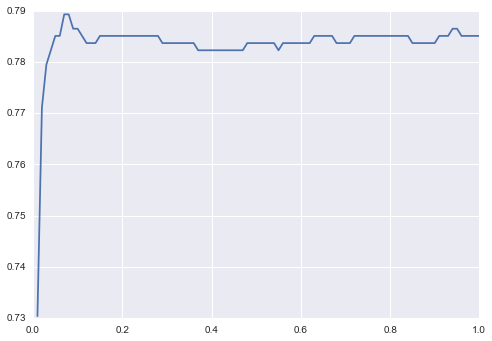

In [26]:
plot_score(clf, x_param='C')

## Ridge Regression

In [27]:
from sklearn import linear_model as lm

In [28]:
# Naive

clf = lm.RidgeClassifier()
clf.fit(X, y.values)
print("Training Score: ", clf.score(X, y))
yhats['ridge_0'] = clf.predict(test[feature_labels].values)

Training Score:  0.796348314607


In [29]:
# normalize
clf = lm.RidgeClassifier(normalize=True)
clf.fit(X, y.values)
print("Training Score: ", clf.score(X, y))
yhats['ridge_normalized'] = clf.predict(test[feature_labels].values)

Training Score:  0.780898876404


In [30]:
# gs over alpha

clf = lm.RidgeClassifierCV(alphas=np.linspace(0, 1, 100))
clf.fit(X, y.values)
print("Best alpha: ", clf.alpha_)
print("Training Score: ", clf.score(X, y))
yhats['ridge_cv_alpha'] = clf.predict(test[feature_labels])

Best alpha:  1.0
Training Score:  0.796348314607


## SVC

In [31]:
from sklearn import svm

In [32]:
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid={'C': np.linspace(.01, 1, 100)})
clf.fit(X, y)
print("Training score: ", clf.best_score_)
yhats['svc_cv'] = clf.predict(test[feature_labels].dropna().dropna().values)

Training score:  0.691011235955


## NuSVC

## Nearest Neighbors

In [33]:
from sklearn import neighbors

In [34]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X, y)
print("Training Score: ", clf.score(X, y))
yhats['knn_0'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.790730337079


In [35]:
knn = neighbors.KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid={'n_neighbors': [1, 3, 5, 10, 20], 'p': [1, 2]})
clf.fit(X, y)
print("Training Score: ", clf.best_score_)
yhats['knn_cv'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.695224719101


## Decision Tree

In [36]:
from sklearn import tree

In [37]:
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
print("Training Score: ", clf.score(X, y))
yhats['tree_0'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.98595505618


In [38]:
params = dict(criterion=['gini', 'entropy'],
              splitter=['best', 'random'],
              max_features=[None, 'auto', 'sqrt', 'log2'],
              max_depth=[None, 4, 8, 12])

dt = tree.DecisionTreeClassifier()
clf = GridSearchCV(dt, params)
clf.fit(X, y)
print("Training Score", clf.best_score_)
yhats['tree_cv'] = clf.best_estimator_.predict(test[feature_labels].dropna().values)

Training Score 0.794943820225


## Ensembe Methods

In [39]:
from sklearn import ensemble

In [40]:
clf = ensemble.RandomForestClassifier()
clf.fit(X, y)
print("Training Score: ", clf.score(X, y))
yhats['random_forrest_0'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.960674157303


In [41]:
params['n_estimators'] = [5, 10, 15, 25, 35]
params.pop('splitter')
rfc = ensemble.RandomForestClassifier()
clf = GridSearchCV(rfc, params)
clf.fit(X, y)
print("Training Score", clf.best_score_)
yhats['rfc_cv'] = clf.best_estimator_.predict(test[feature_labels].dropna().values)

Training Score 0.821629213483


In [42]:
clf = ensemble.ExtraTreesClassifier()
clf.fit(X, y)
print("Training Score: ", clf.score(X, y))
yhats['extra_tree_0'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.98595505618


In [43]:
erfc = ensemble.ExtraTreesClassifier()
clf = GridSearchCV(erfc, params)
clf.fit(X, y)
print("Training Score", clf.best_score_)
yhats['erfc_cv'] = clf.best_estimator_.predict(test[feature_labels].dropna().values)

Training Score 0.816011235955


In [44]:
clf = ensemble.AdaBoostClassifier()
scores = cv.cross_val_score(clf, X, y)
print("Training Score: ", scores.mean())

Training Score:  0.797811107565


In [45]:
abc = ensemble.AdaBoostClassifier()

params = dict(n_estimators=[20, 30, 40, 50, 75, 100],
              learning_rate=[.1, .25, .5, .75, .9, 1])

clf = GridSearchCV(abc, params)
clf.fit(X, y)
print("Training Score: ", clf.best_score_)
yhats['ada_boost'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.800561797753


### Gradiant Boosting

In [46]:
clf = ensemble.GradientBoostingClassifier()
cv.cross_val_score(clf, X, y).mean()

0.80341925799855807

In [47]:
gbc = ensemble.GradientBoostingClassifier()

clf = GridSearchCV(gbc, params)
clf.fit(X, y)
print("Training Score: ", clf.best_score_)
yhats['gbc'] = clf.predict(test[feature_labels].dropna().values)

Training Score:  0.823033707865
